# main
- TODO: Something to do with local high. Filter so that only count if current rally's high is the highest for past 7 days or something

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns


In [2]:
import metalabeller as ml
import ta

In [362]:
# df = dl.get_working_data("BTCUSDT")

df = dl.get_working_data("ATOMUSDT", span="h")
# df = dl.get_working_data("HNTUSDT", span="h")
# df = dl.get_working_data("ADAUSDT", span="h")

# df = dl.get_working_data("DOTUSDT")
# df = dl.get_working_data("DOGEUSDT")
# df = dl.get_working_data("ADAUSDT")
# df = dl.get_working_data("BATUSDT")
# df = dl.get_working_data("SOLUSDT")

In [363]:
df["macd"] = ta.macd(df.close, result="hist")
df["macd_past"] = df.macd.shift(1)
df["ema"] = df.close.ewm(span=500).mean()
df["ema_diff"] = df.ema.diff()
df.dropna(inplace=True)
t0 = df[(df.macd<0) & (df.macd_past>0)].index
tn1 = df[(df.macd>0) & (df.macd_past<0)].index

In [364]:
def get_base_macd_events(df, tn1, t0, mlen=3, stdev=1):
    """
    returns all macd events satisfying criteria:
    - length > mlen
    - gain is at least stdev standard deviations
    """
    stats = ["tn1", "t0", "gain", "length"]
    result = pd.DataFrame(np.nan, index=range(len(t0)), columns=stats)
    ls = tn1.searchsorted(t0, side='left', sorter=None)-1   # location of start (corresponding
                                                            # tn1 for t0
    for i in range(len(t0)):
        if ls[i]<0: continue 
        if tn1[ls[i]]-pd.Timedelta(days=7) not in df.index: continue
        df_ = df.loc[tn1[ls[i]]:t0[i]]
        if df_.shape[0]<mlen: continue
        
        row = dict.fromkeys(stats, 0.)
        row["tn1"] = tn1[ls[i]]
        row["t0"] = t0[i]
        row["gain"] = (max(df_.high)-df_.iloc[0].close)/df_.iloc[0].close
        row["length"] = len(df_)
        result.iloc[i] = row
    
    min_gain = np.mean(result.gain)+stdev*np.std(result.gain)
    result = result[result.gain > min_gain]
    result.dropna(inplace=True)
    result.index = range(len(result))
    return result

In [365]:
import time

In [366]:
t = time.time()
result_ = get_base_macd_events(df, tn1, t0, mlen=3, stdev=1)
time.time()-t

2.776047945022583

In [367]:
print(f"min: {round(np.min(result_.gain)*100, 2)}%\n\
median: {round(np.median(result_.gain)*100, 2)}%\n\
mean: {round(np.mean(result_.gain)*100, 2)}%\n\
max: {round(np.max(result_.gain)*100, 2)}%\n\
std: {round(np.std(result_.gain)*100, 2)}%")

min: 7.73%
median: 11.05%
mean: 12.75%
max: 32.35%
std: 5.36%


In [368]:
result_.tail()

,tn1,t0,gain,length
135,2021-10-12 13:00:00,2021-10-12 22:00:00,0.080189,10.0
136,2021-10-13 14:00:00,2021-10-14 04:00:00,0.079581,15.0
137,2021-10-20 09:00:00,2021-10-20 22:00:00,0.086572,14.0
138,2021-10-23 00:00:00,2021-10-23 18:00:00,0.081710,19.0
139,2021-10-26 09:00:00,2021-10-26 20:00:00,0.144493,12.0


In [369]:
def get_macd_events(df, events, min_length=3):
    """
    returns macd events, starting at tn1 when macd crosses signal to the upside, 
    and t0 when macd crosses back down the signal. 
    df has columns [open, high, low, close, volume]
    tn1 and t0 are DatetimeIndex.
    min_length is how short a trend leg can be, in bars amount. Must be at least 3
    
    returns dataframe of events with columns
    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg
    - macd: highest macd value
    - macd_avg: average macd value 
    - md1/7: momentum divergence for past 1/7 days
    - dm1/7: downward momentum for past 1/7 days
    """
    stats = ["gain", "vdiff7", "vdiff30", "vmax", "length", "end", "h1", "h2", "h3", "hr7", "hr30", 
             "v0", "v1", "cr", "cr7", "cr30", "cr1", "cr2", "cr3", 
             "macd", "macd_avg", "md1", "md7", "dm1", "dm7", "trend", "lh"]
    result = pd.DataFrame(np.nan, index=events.t0, columns=stats)

    for i in range(len(events)):
        if events.tn1[i]-pd.Timedelta(days=7) not in df.index: continue
        df_ = df.loc[events.tn1[i]:events.t0[i]]
        df_1 = df.loc[events.tn1[i]-pd.Timedelta(days=1):events.t0[i]]
        df_7 = df.loc[events.tn1[i]-pd.Timedelta(days=7):events.t0[i]]
        if df_.shape[0]<min_length: continue
        row = dict.fromkeys(stats, 0.)
        row["gain"] = events.gain[i]
        row["vdiff7"] = (sum(df_.volume)/df_.shape[0])/(sum(df_1.volume)/df_1.shape[0])
        row["vdiff30"] = (sum(df_.volume)/df_.shape[0])/(sum(df_7.volume)/df_7.shape[0])
        row["vmax"] = get_max_vol_in_leg(df_)
        row["length"] = len(df_)
        row["end"] = get_pct_pullback(df_)
        row["h1"], row["h2"], row["h3"] = get_heights(df_)
        row["hr7"] = get_height(df_)/get_height(df_1)
        row["hr30"] = get_height(df_)/get_height(df_7)
        row["v0"], row["v1"] = get_volume_before_after(df_)
        row["cr"] = get_close_relative(df_)
        row["cr7"] = row["cr"]/get_close_relative(df_1)
        row["cr30"] = row["cr"]/get_close_relative(df_7)
        row["cr1"], row["cr2"], row["cr3"] = get_triple_close_relative(df_)
        row["macd"] = max(df_.macd)/df_.iloc[0].close
        row["macd_avg"] = sum(df_.macd)/(df_.iloc[0].close*df_.shape[0])
        row["md1"] = max(df_.macd)/max(df_1.macd) #momentum divergence, 1 is none, 0.5 is half 
        row["md7"] = max(df_.macd)/max(df_7.macd)
        row["dm1"] = -min(df_1.macd)/max(df_.macd) #downward momentum
        row["dm7"] = -min(df_7.macd)/max(df_.macd)
        row["trend"] = sum(df_7.ema_diff)/(df_7.shape[0]*df_.iloc[0].close)
        row["lh"] = max(df_.high) == max(df_7.high)

        result.iloc[i] = row
    return result.dropna()
        
        

    

In [370]:
def get_max_vol_in_leg(df):
    """returns max volume hour divided by all volume in impulse buy """
    v = max(df.volume)
    return v/sum(df.volume)

def get_pct_pullback(df):
    """(close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback"""
    return (df.iloc[-1].close-df.iloc[0].low)/(max(df.high)-df.iloc[0].low)

def get_heights(df):
    """returns ranges of the bars, over mean of all bars in the impulse buy"""
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    t = get_height(df)
    return get_height(df.iloc[:a])/t, get_height(df.iloc[a:b])/t, get_height(df.iloc[b:])/t
    
def get_height(df):
    return sum(map(lambda h,l: h-l, df.high, df.low))/df.shape[0]

def get_volume_before_after(df):
    ind = list(df.high).index(max(df.high))+1
    vol = sum(df.volume)
    return sum(df.iloc[:ind].volume)/vol, sum(df.iloc[ind:].volume)/vol

def get_close_relative(df):
    """returns the mean close relative to bar for entire df. 
    Closing halfway between high and low returns 0.5"""
#     def cr(h,l,c):
#         return (c-l)/(h-l) if (h-l!= 0) else 0
    return sum(map(lambda h, l, c: (c-l)/(h-l) if (h-l!= 0) else 0, df.high, df.low, df.close))/df.shape[0]

def get_triple_close_relative(df):
    """
    returns close relative for third segments of df over total
    """
    t = get_close_relative(df)
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    return get_close_relative(df.iloc[:a])/t, get_close_relative(df.iloc[a:b])/t, get_close_relative(df.iloc[b:])/t

In [371]:
events_ = get_macd_events(df, result_, min_length=3)

In [372]:
events_.tail()

,gain,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,...,cr2,cr3,macd,macd_avg,md1,md7,dm1,dm7,trend,lh
t0,,,,,,,,,,,,,,,,,,,,,
2021-10-12 22:00:00,0.080189,1.682972,1.844228,0.288249,10,0.79669,1.678877,0.677656,0.750916,1.395789,...,0.695468,0.961617,0.052188,0.023682,1.0,1.0,0.480831,0.685526,-0.00013,False
2021-10-14 04:00:00,0.079581,1.110277,1.562157,0.220446,15,0.737542,0.938449,1.330523,0.731029,0.996639,...,1.380287,0.690342,0.040459,0.01433,0.790372,0.790372,1.008624,1.008624,-0.000153,False
2021-10-20 22:00:00,0.086572,0.983851,1.473849,0.201779,14,0.700658,0.586353,1.478235,1.031059,0.932179,...,1.127898,0.950736,0.03371,0.01397,1.0,0.872763,0.751028,0.861911,-0.000131,True
2021-10-23 18:00:00,0.08171,1.079772,1.462605,0.156717,19,0.632653,0.633844,1.303471,1.012107,1.03204,...,1.162984,0.7404,0.023748,0.009393,1.0,0.713412,0.914979,1.052727,-0.000045,True
2021-10-26 20:00:00,0.144493,2.100528,3.183886,0.170199,12,0.853791,0.98826,1.249309,0.762431,1.619083,...,0.930392,1.020021,0.034324,0.018109,1.0,1.0,0.21796,0.682888,0.000102,True


In [446]:
events = events_[events_.trend>0]
events = events[events.lh]
# events = events[events.cr7<np.mean(events.cr7)-np.std(events.cr7)]
events = events[events.md7==1.0]
events.drop(["lh"], axis=1, inplace=True)
print(f"length = {events.shape[0]}")

length = 27


In [447]:
events.tail()

,gain,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,...,cr1,cr2,cr3,macd,macd_avg,md1,md7,dm1,dm7,trend
t0,,,,,,,,,,,,,,,,,,,,,
2021-08-21 18:00:00,0.246025,1.642484,2.264755,0.273264,16,0.812598,0.511197,1.445731,0.953925,1.347087,...,1.185685,1.165012,0.616302,0.091693,0.033294,1.0,1.0,0.216396,0.73949,0.000656
2021-08-31 00:00:00,0.187097,1.442283,1.87535,0.178164,16,0.584856,0.560563,0.988263,1.453521,1.247255,...,0.875303,1.272365,0.797859,0.078933,0.026795,1.0,1.0,0.384693,0.49648,0.000549
2021-09-12 19:00:00,0.253304,1.309233,1.321993,0.164286,17,0.789474,0.763238,1.06067,1.186204,1.159289,...,1.214579,1.129663,0.677369,0.05964,0.030843,1.0,1.0,0.665119,1.563927,0.000557
2021-09-13 21:00:00,0.192225,1.494668,2.605854,0.213364,11,0.605905,1.210516,1.235601,0.612783,1.253132,...,1.152691,1.228157,0.676191,0.097285,0.041982,1.0,1.0,0.507505,0.799401,0.000563
2021-10-26 20:00:00,0.144493,2.100528,3.183886,0.170199,12,0.853791,0.98826,1.249309,0.762431,1.619083,...,1.049587,0.930392,1.020021,0.034324,0.018109,1.0,1.0,0.21796,0.682888,0.000102


In [448]:
t_events = events.index

In [449]:
# vol = ml.get_daily_vol(df.close)
# t_events = ml.get_t_events(df.close, vol, 0.02)
t1 = ml.get_vertical_barrier(df.close, t_events, 7)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


In [450]:
# side = pd.Series(np.random.randint(0, 2, len(t_events)), index=t_events)

In [451]:
# # create target series
# ptsl = [1,1]
# min_ret = 0.00
    
# # events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=side)
# events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=pd.Series(1.,index=t_events))

# events

In [490]:
pd.options.mode.chained_assignment = None
events["t1"] = t1
events["trgt"] = events.gain*events.cr*2

In [491]:
# labels = ml.get_bins(events, df.close, t1)

In [492]:
def get_bins(events, df):
    """generates labels with t0 index, return, and target"""
    out = pd.DataFrame(index=events.index, columns=["ret", "target"])
    for t in events.index:
        event = events.loc[t]
        df_ = df.loc[t:event.t1]
        tp_price = event.trgt*df_.iloc[0].close+df_.iloc[0].close
        sl_price = -event.trgt*df_.iloc[0].close+df_.iloc[0].close
        tp = df_[df_.high>tp_price].index
        sl = df_[df_.low<sl_price].index
#         return out, t, {"ret":(df_.iloc[-1].close-df_.iloc[0].close)/df_.iloc[0].close, "target":0}
        if len(tp)==0 and len(sl)==0: 
            out.loc[t] = {"ret":(df_.iloc[-1].close-df_.iloc[0].close)/df_.iloc[0].close, "target":0}
        elif len(tp)==0: 
            out.loc[t] = {"ret":-event.trgt, "target":0}
        elif len(sl)==0: 
            out.loc[t] = {"ret":event.trgt, "target":1}
        else: 
            out.loc[t] = {"ret":event.trgt if tp[0]<sl[0] else -event.trgt, 
                           "target": 0 if tp[0]<sl[0] else 0}
    return out

In [493]:
labels = get_bins(events, df)

In [494]:
labels.target.value_counts()

0.0    18
1.0     9
Name: target, dtype: int64

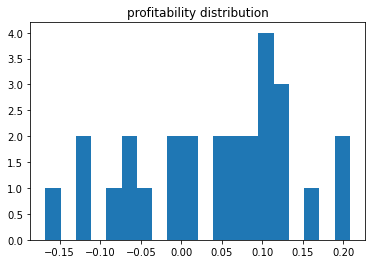

In [495]:
fig, ax = plt.subplots()
ax.set_title('profitability distribution')
ax.hist(labels.ret, bins=20)
plt.show()

In [496]:
print(f"mean: {round(np.mean(labels.ret)*100,4)}%\nmedian: {round(np.median(labels.ret)*100, 4)}%")

mean: 3.9077%
median: 5.8371%


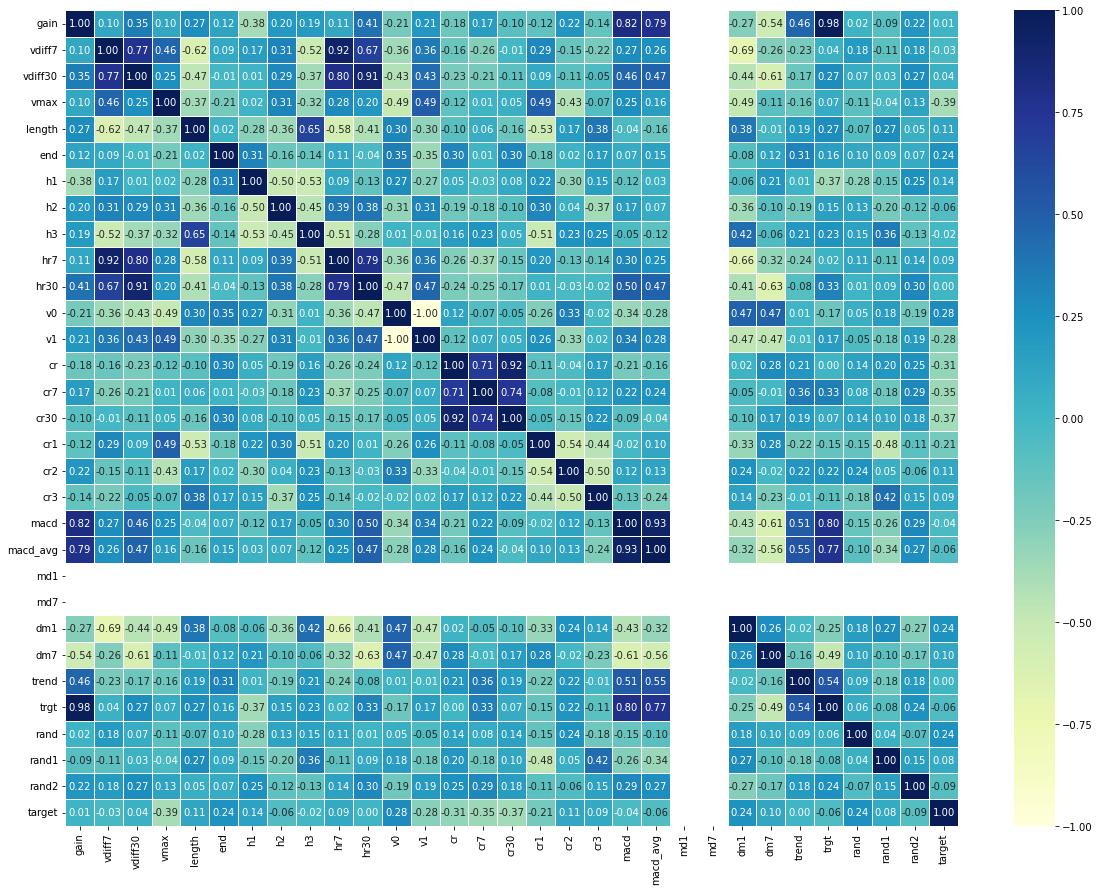

In [530]:
indicators = list(events.columns)
indicators.append("target")

# d = df[list(indicators)].copy()
d = events.copy()
d["rand"] = list(np.random.random(len(d)))
d["rand1"] = list(np.random.random(len(d)))
d["rand2"] = list(np.random.random(len(d)))

d["target"] = list(labels.ret)
d.drop(["t1"], axis=1, inplace=True)
d = d.astype(float)
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg

In [498]:
i = -1

In [526]:
i+=1
item = events.index[i]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df.loc[item-pd.Timedelta(days=14):t1[item]+pd.Timedelta(days=7)].close, c="black", alpha=0.3)
ax.plot(df.loc[item:events.loc[item].t1].close, c="orange", alpha=0.8)
ax.axhline(df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="green", alpha=0.2)
ax.axhline(-df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="red", alpha=0.2)


IndexError: index 27 is out of bounds for axis 0 with size 27

In [719]:
# summary = pd.DataFrame(index=corr_matrix.columns)

In [746]:
summary["BTC"] = corr_matrix.target

In [693]:
summary.loc["gain"]

SOL    -0.217596
ATOM   -0.240027
DOT    -0.214604
DOGE   -0.184628
ADA    -0.119990
BAT    -0.174644
Name: gain, dtype: float64

In [750]:
summary["mean"] = summary.mean(axis=1)

In [751]:
summary

,SOL,ATOM,DOT,DOGE,ADA,BAT,BTC,mean
gain,-0.217596,-0.240027,-0.214604,-0.184628,-0.119990,-0.174644,-0.198723,-0.192887
vdiff7,0.335390,-0.166177,0.038060,0.080419,0.084685,-0.075697,-0.096352,0.028618
vdiff30,0.261178,-0.128315,0.163970,-0.082962,-0.002778,-0.024412,-0.180449,0.000890
vmax,-0.213792,0.040328,0.221536,-0.144262,0.058868,0.019582,-0.116591,-0.019190
length,0.118877,-0.041678,-0.343917,0.195346,-0.130409,0.111587,0.052261,-0.005419
end,0.085050,-0.065674,0.158951,0.306155,-0.048958,0.147212,-0.074196,0.072649
h1,0.137202,0.089176,0.359611,0.141914,-0.030123,-0.048954,0.008070,0.093842
h2,0.202280,-0.163445,0.146303,-0.112242,0.063419,0.014834,-0.151221,-0.000010
h3,-0.195148,0.072468,-0.475269,0.013025,-0.044505,0.044099,0.121933,-0.066200
hr7,0.242766,-0.184757,-0.003930,-0.074074,0.044224,-0.026635,-0.136539,-0.019849


In [33]:
t1

timestamp
2017-09-18 15:00:00   2017-09-20 15:00:00
2017-09-29 19:00:00   2017-10-01 19:00:00
2017-10-09 23:00:00   2017-10-11 23:00:00
2017-10-12 17:00:00   2017-10-14 17:00:00
2017-10-13 07:00:00   2017-10-15 07:00:00
                              ...        
2021-10-15 09:00:00   2021-10-17 09:00:00
2021-10-15 22:00:00   2021-10-17 22:00:00
2021-10-20 20:00:00   2021-10-22 20:00:00
2021-11-01 14:00:00   2021-11-03 14:00:00
2021-11-04 02:00:00   2021-11-06 02:00:00
Name: timestamp, Length: 408, dtype: datetime64[ns]

In [14]:
lookback = 4000
def get_z_score(a, b):
    """Returns the latest zscore between dataframes a and b. IF NAN, RETURN PREVIOUS"""
    a = a.set_index("timestamp") #Do not set inplace cause reference
    b = b.set_index("timestamp")

    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)

    df.dropna(inplace=True)

    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] = spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    return get_non_nan_zscore(spread)    
    
def get_non_nan_zscore(spread):
    """loops through spread finding latest non-nan zscore"""
    zscore = spread.iloc[-1].zscore
    i = 2
    while math.isnan(zscore):
        zscore = spread.iloc[-i].zscore
        i += 1
    return zscore

In [10]:
a = dl.get_minutely_data("HNTUSDT", past=False)
b = dl.get_minutely_data("BTCUSDT", past=False)

In [17]:
z = get_z_score(a, b)

In [18]:
z

-0.15050287861225423

In [803]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,accuracy_score 
from scipy.stats import weightedtau


In [855]:
X_train = d.drop(["target"], axis=1, errors="ignore")[:50]
y_train = d["target"][:50]

X_test = d.drop(["target"], axis=1, errors="ignore")[50:]
y_test = d["target"][50:]

In [856]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,class_weight='balanced',min_weight_fraction_leaf=0) 
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,max_features=1.,max_samples=1,oob_score=True,n_jobs=1) 
fit=clf.fit(X=X_train,y=y_train, sample_weight=pd.Series(list(np.full(fill_value=0.1, shape=len(X_train))), index=X_train.index)) 

In [857]:
oob=fit.oob_score_

In [858]:
oob

0.6

In [859]:
class PurgedKFold(KFold):
    #Extend KFold class to work with labels that span intervals
    #The train is purged of observations overlapping test-label intervals
    #Test set is assumed contiguous (shuffle=False), w/o training samples in between 
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None) 
        self.t1=t1
        self.pctEmbargo=pctEmbargo
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index') 
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in \
            np.array_split(np.arange(X.shape[0]),self.n_splits)] 
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j] 
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max()) 
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index) 
            if maxT1Idx<X.shape[0]: # right train (with embargo)
                train_indices=np.concatenate((train_indices,indices[maxT1Idx+mbrg:])) 
            yield train_indices,test_indices

In [860]:
def featImpMDI(fit,featNames):
    '''feat importance based on IS mean impurity reduction'''
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)} 
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),'std':df0.std()*df0.shape[0]**-.5},axis=1) 
    imp/=imp['mean'].sum()
    return imp

In [861]:
imp=featImpMDI(fit,featNames=X_train.columns) 
# oos=cvScore(clf,X=X_train,y=y_train,cv=10,sample_weight=pd.Series(list(np.full(fill_value=0.1, shape=len(X_train))), index=X_train.index), 
#             t1 = events.t1[:40], pctEmbargo=0,scoring="accuracy").mean() 
            

In [862]:
fit.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [863]:
y_test

t0
2021-05-07 16:45:00    0.0
2021-07-05 05:15:00    1.0
2021-07-05 21:30:00    0.0
2021-07-11 00:00:00    0.0
2021-08-17 12:15:00    0.0
2021-08-17 20:15:00    0.0
2021-08-18 19:00:00    1.0
2021-08-19 02:00:00    0.0
2021-08-21 13:45:00    1.0
2021-08-30 21:15:00    0.0
2021-08-31 09:45:00    0.0
2021-09-09 17:00:00    0.0
2021-09-10 01:30:00    0.0
2021-09-11 00:30:00    0.0
2021-09-12 15:00:00    1.0
2021-09-13 00:45:00    0.0
2021-09-18 15:00:00    0.0
2021-09-19 16:45:00    0.0
Name: target, dtype: float64

In [846]:
oob

0.65

In [847]:
imp

,mean,std
gain,NaN,NaN
vdiff7,NaN,NaN
vdiff30,NaN,NaN
vmax,NaN,NaN
length,NaN,NaN
end,NaN,NaN
h1,NaN,NaN
h2,NaN,NaN
h3,NaN,NaN
hr7,NaN,NaN
